# Growing Task: Growing NCA
The paper ["Growing Neural Cellular Automata"](https://distill.pub/2020/growing-ca) is particularly important for the NCA research field. It was the very first paper about NCAs and coined the term we know today. So what better point to start our dive into NCAs if not here? 

Growing NCA focuses on self-organizing structures. The models learn to grow from a seed to a target image by learning the growth rules via gradient descent. In order to implement this, we closely follow [this implementation](https://github.com/JohnRomanelis/NeuralCellularAutomata-PyTorch). We highly recommend reading the original paper for a more detailed explanation.
## Implementation Overview
Our version of the Growing NCA implementation:
1. **Core Implementation**: Defining the architecture of the Growing NCA model
2. **Utilities and Visualizations**: Creating the seed and visualization methods
3. **Training Loop**: Training the model


## 0. Imports
Import all necessary libraries and set your device.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import fastcore.all as fc
from IPython.display import HTML
from PIL import Image
from tqdm import tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## 1. Core Implementation
Here we implement the core architecture of the Growing NCA. Below you'll also find a visualization of a single update step.

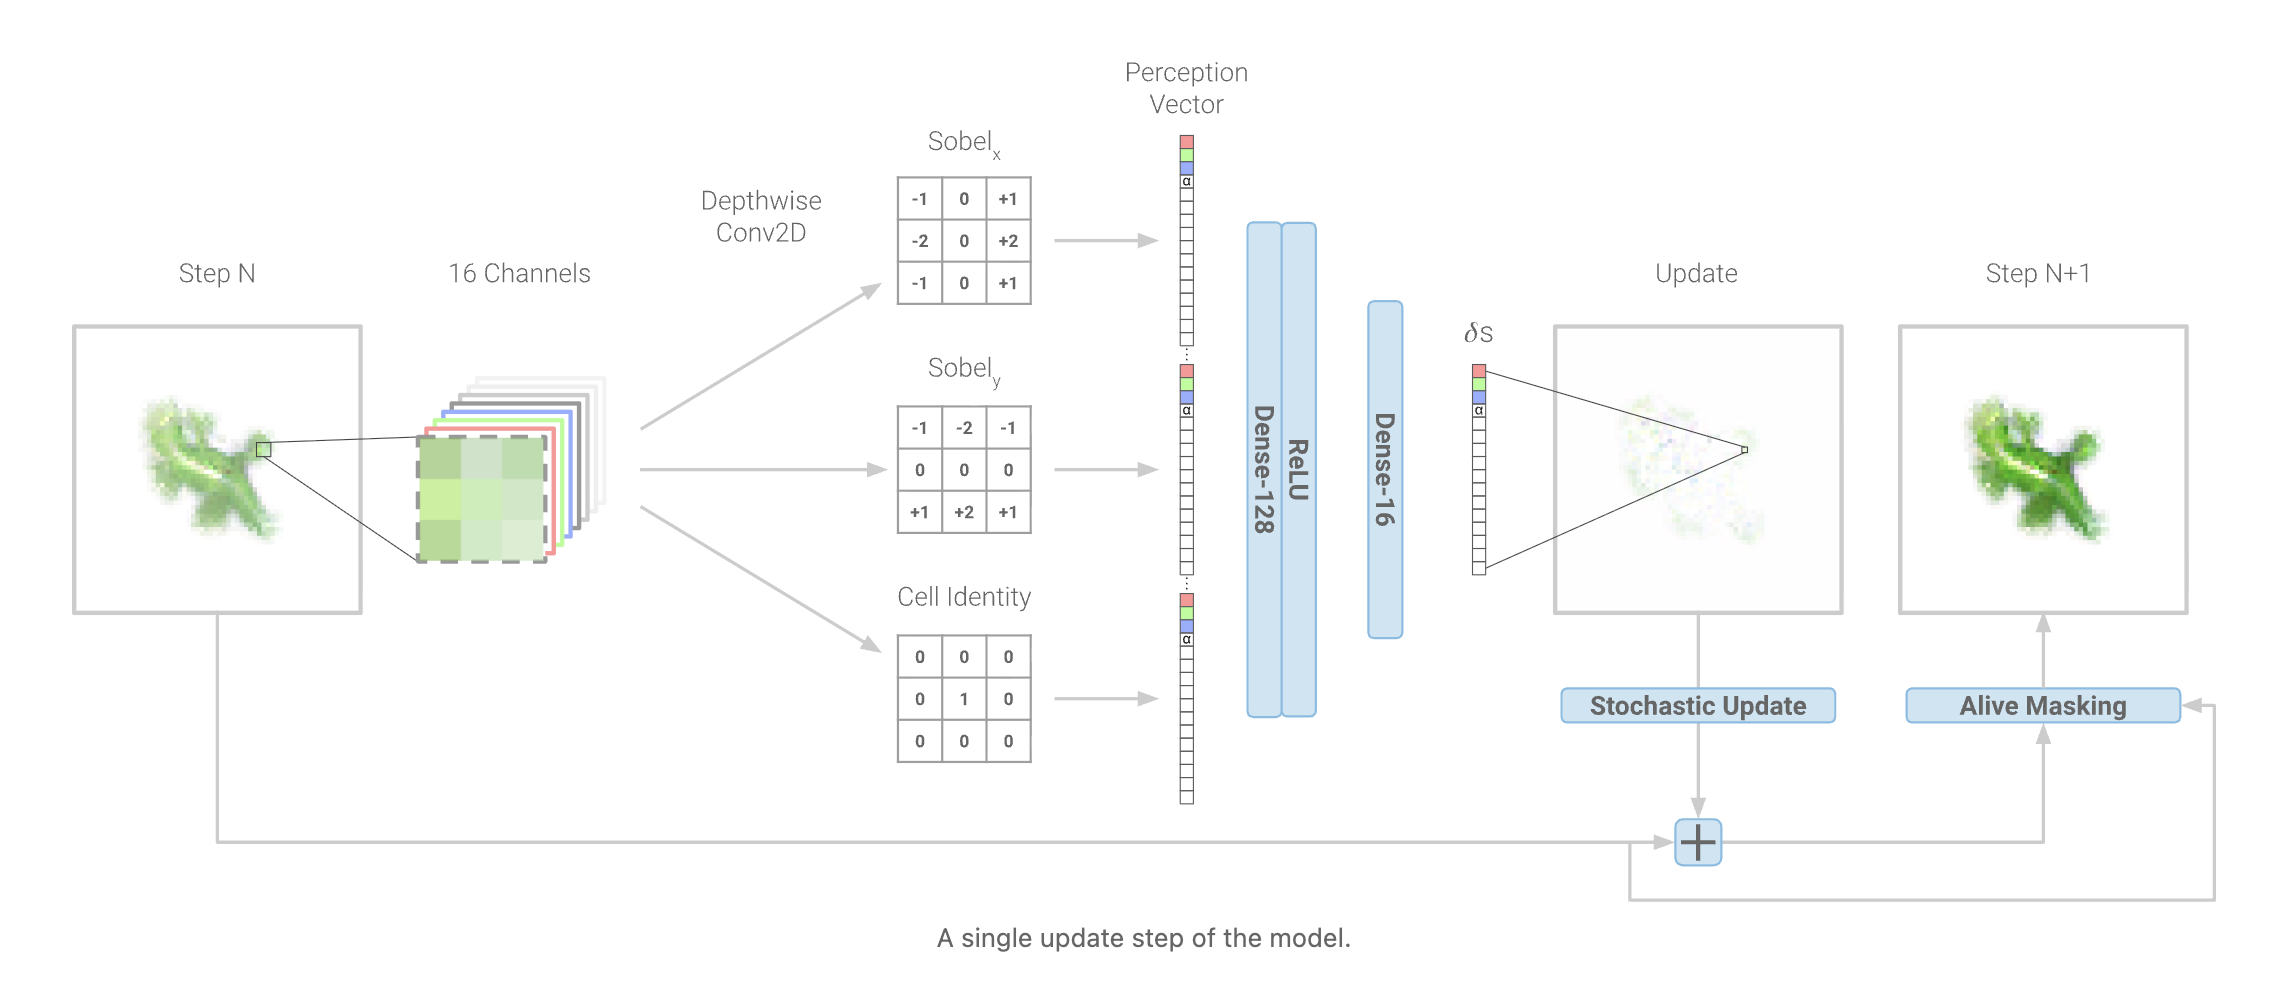

[Source](https://distill.pub/2020/growing-ca/)

In [ ]:
def get_kernels():
    """Define Identity and Sobel filters to sense local environment"""
    identity = torch.tensor([[0,0,0,], [0,0,0], [0,0,0]], dtype=torch.float32)
    sobel_x = torch.tensor([[-1,0,1,], [-2,0,2], [-1,0,1]], dtype=torch.float32)
    sobel_y = sobel_x.T
    return torch.stack([identity, sobel_x, sobel_y]).to(DEVICE)

KERNELS = get_kernels()

def perception(x):
    """Apply perception kernels to input"""
    b, c, h, w = x.shape
    y = x.reshape(b*c, 1, h, w)
    y = F.pad(y, (1, 1, 1, 1), mode='circular')
    y = F.conv2d(y, KERNELS[:, None])
    return y.reshape(b, -1, h, w)

def is_alive(x, threshold=0.1):
    """Determine which cells are alive"""
    x = F.pad(x, (1, 1, 1, 1), mode='circular')
    return F.max_pool2d(x, 3, stride=1, padding=0) > threshold

class NCAModel(nn.Module):
    def __init__(self, n_channels=16, fire_rate=0.5):
        super().__init__()
        self.n_channels = n_channels
        self.fire_rate = fire_rate

        self.net = nn.Sequential(
            nn.Conv2d(n_channels*3, 128, 1),
            nn.ReLU(),
            nn.Conv2d(128, n_channels, 1, bias=False)
        )

        with torch.no_grad():
            self.net[-1].weight.zero_()

    def forward(self, x, steps=1):
        for i in range(steps):
            x = self.step(x)
        return x
    
    def step(self, x, update_rate=None):
        if update_rate is None:
            update_rate = self.fire_rate
        y = perception(x)
        y = self.net(y)

        b, c, h, w = y.shape
        update_mask = (torch.rand(b, 1, h, w, device= x.device) + self.fire_rate).floor()
        x = x + y * update_mask

        life_mask = is_alive(x[:, 3:4])
        x = x * life_mask

        return x

## 2. Utilities and Visualization
Here we create the initial seed, which is a single active cell as well as visualization methods.

In [ ]:
SIZE = 40

def make_seed():
    """Create initial seed"""
    seed = torch.zeros(1, 16, SIZE, SIZE, device=DEVICE)
    cx, cy = SIZE//2, SIZE//2
    seed[0, 3, cx, cy] = 1.0
    return seed

def load_img(path):
    """Load target image"""
    img = Image.open(path).convert('RGBA').resize((SIZE, SIZE))
    arr = np.array(img, dtype=np.float32) / 255.0
    tensor = torch.tensor(arr).permute(2,0,1)[None].to(DEVICE)
    return tensor

def display_animation(images): 
    """Create and display an animation"""
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    ims = [[plt.imshow(image, animated=True)] for image in images]
    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return HTML(ani.to_jshtml()) 

@fc.patch
def grow_animation(self: NCAModel, seed, steps, update_rate=None):
    """Generate a growing animation from seed"""
    x = seed.clone()
    images = [torch.clamp(x[0, :4].detach().cpu().permute(1, 2, 0), 0, 1)]
    for _ in range(steps):
        x = self.step(x, update_rate=update_rate)
        images.append(torch.clamp(x[0, :4].detach().cpu().permute(1, 2, 0), 0, 1))
    return images

## 3. Training Loop
In order to train the model, you'll need a target image. In the original paper, emojis were used as target images.

An example dataset can be found here: https://www.kaggle.com/datasets/something4kag/nca-emoji-challenge-images/data but any image with the correct dimensions should suffice.
With a target image set, we can now train our model and display the result. 

In [ ]:
# Training parameters
epochs = 8000
batch_size = 8
lr = 2e-3
lr_decay = 0.9999

# Initialize model and load image
seed = make_seed()
target = load_img('target/path') #insert your target image!

model = NCAModel().to(seed.device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)

# Create batch inputs
model_input = seed.repeat(batch_size, 1, 1, 1)
target_batch = target.repeat(batch_size, 1, 1, 1)

# Actual training loop
for i in tqdm(range(epochs)):
        optimizer.zero_grad()
        n_steps = torch.randint(64, 96, (1,)).item()
        output = model(model_input, steps=n_steps)

        loss = F.mse_loss(output[:, :4], target)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Print training progress
        if i % 500 == 0:
            print(f"Epoch: {i} Loss: {loss.item():.6f}")

# Visualize the result
images = model.grow_animation(seed, 200)
display_animation(images) 